In [51]:
import os
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import hist
from hist import Hist
import os, sys
import re
import pickle
import vector
import mplhep as hep
import math
from tabulate import tabulate
from collections import defaultdict

vector.register_awkward()

# parameters for matplotlib styling
plt.style.use(hep.style.CMS)

matplotlib.rcParams.update({'figure.max_open_warning': 0})
matplotlib.rcParams.update({'font.size': 20})

In [52]:
# parameters
unblind = False                               # don't show D_obs for SUEP
input_label = 'V5_nconst10'
output_label = 'outputs/SUEPV5'
file_ext = '.pdf'

# default
plotDir = os.environ['HOME']+"/SUEP/SUEPCoffea_dask/plotting/outputs/"
infile_name_data = plotDir+'JetHT_' + input_label + '.pkl'
infile_name_QCD = plotDir+'QCD_' + input_label + '.pkl'
files = [infile_name_data, infile_name_QCD]

In [53]:
# function to load files from pickle
def openpkl(infile_name):
    with (open(infile_name, "rb")) as openfile:
        plots = pickle.load(openfile)
        plots.update(pickle.load(openfile))
    return plots

def plot1d(h, ax, label, color='midnightblue', lw=1):
    values, x = h.to_numpy()
    ax.step(x[:-1],values, label=label, color=color, lw=lw)
    ax.set_xlabel(h.axes[0].label)
    ax.set_ylabel("Events")
    
def plot2d(h, ax, log=False):
    w, x, y = h.to_numpy()
    if log: mesh = ax.pcolormesh(x, y, w.T, cmap="RdYlBu", norm=matplotlib.colors.LogNorm())
    else: mesh = ax.pcolormesh(x, y, w.T, cmap="RdYlBu")
    ax.set_xlabel(h.axes[0].label)
    ax.set_ylabel(h.axes[1].label)
    fig.colorbar(mesh)
    
def find_nth(string, substring, n):
    if (n == 1):
        return string.find(substring)
    else:
        return string.find(substring, find_nth(string, substring, n - 1) + 1)
    
def combine_bins(x, y, e, n=4):
    old_e = e
    old_y = y
    old_x = x
    
    y = []
    x = []
    e = []
   
    for j in list(range(0,len(old_y), n)):
        y.append(np.sum(old_y[j:j+n])/n)
        x.append(np.sum(old_x[j:j+n])/n)
        e.append(np.sum(old_e[j:j+n])/n)
        
    return x, y, e

def nested_dict(n, type):
    if n == 1:
        return defaultdict(type)
    else:
        return defaultdict(lambda: nested_dict(n-1, type))

In [54]:
# dimensions: (real or MC) x (plot label)
plots = {}

# load file(s)
for infile_name in files:
    if not os.path.isfile(infile_name): 
        print("WARNING:",infile_name,"doesn't exist")
    else:
        print("Loading",infile_name)
        if 'QCD' in infile_name:
            plots['QCD_MC'] = openpkl(infile_name)
        if 'Jet' in infile_name:
            plots['data'] = openpkl(infile_name)

Loading /home/submit/lavezzo/SUEP/SUEPCoffea_dask/plotting/outputs/JetHT_V5_nconst10.pkl
Loading /home/submit/lavezzo/SUEP/SUEPCoffea_dask/plotting/outputs/QCD_V5_nconst10.pkl


This nested dictionary stores the number of events and variances in each region for real data and MC data, and it's used to make the comparison table. Dimensions: (real or MC) x (plot label) x (value or error on the value)

In [55]:
data = nested_dict(4,float)

## ABCD Plots
Make ABCD plots for the 4 regions.<br>
Parameters:<br>
`selection`: _str_, which selection to use, e.g. 'ch', 'mult'.<br>
`save`: _bool_, whether to atuomatically save the plots.<br>
`lumi`: _float_, scales MC data.<br>

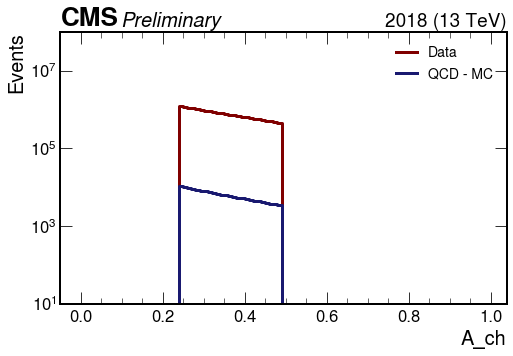

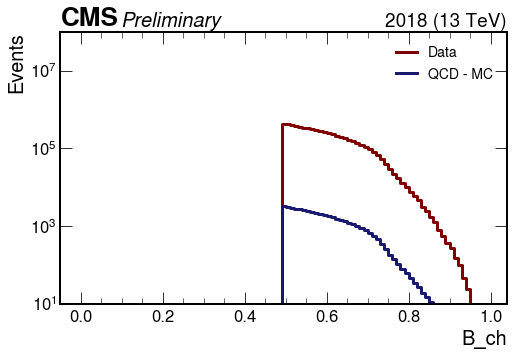

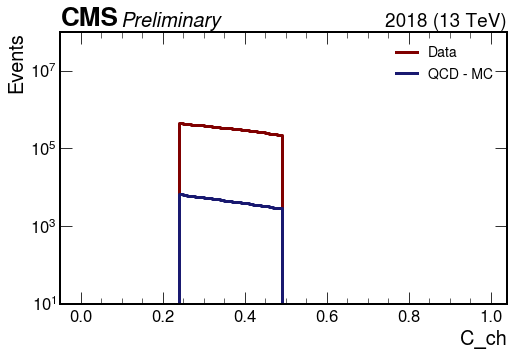

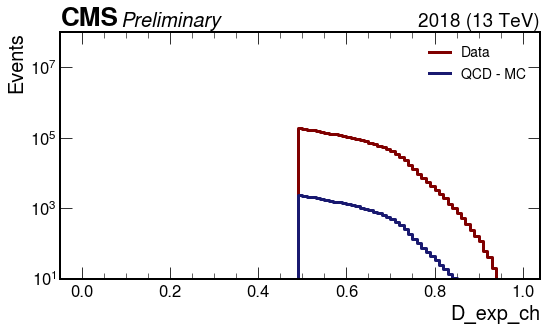

In [56]:
### Make ABCD plots and table based on selection (e.g. 'ch', 'mult')
selection = 'ch'
save = False
lumi = 1

for plot_label in ['A_'+selection,'B_'+selection,'C_'+selection,'D_exp_'+selection,'D_obs_'+selection]:
        
    if 'D_obs' in plot_label and (not unblind): continue
    
    # define figure, axis on which to plot QCD and SUEP
    fig, ax = plt.subplots(figsize=(8,5))
    hep.cms.label("Preliminary", data=True, year=2018)

    # QCD hist for ABCD region
    hdata = plots['data'][plot_label]
    hQCD_MC = plots['QCD_MC'][plot_label]
    
    # plot QCD, sum values and errs
    plot1d(hdata, ax, 'Data', color='maroon', lw=3)
    plot1d(hQCD_MC, ax, 'QCD - MC', color='midnightblue', lw=3)
    
    data['data'][plot_label]["value"] = np.sum(hdata.values())
    data['data'][plot_label]["err"] = np.sum(np.sqrt(hdata.variances()))
    data['QCD_MC'][plot_label]["value"] = np.sum(hQCD_MC.values())
    data['QCD_MC'][plot_label]["err"] = np.sum(np.sqrt(hQCD_MC.variances()))
    
    ax.set_ylim(1e1,1e8)
    ax.set_yscale('log')
    ax.legend(loc='best', fontsize=14, framealpha=1, facecolor='white', shadow=True)
    
    if save: fig.savefig(output_label + "_" + plot_label + file_ext, bbox_inches='tight')

fig.tight_layout()
fig.show()

## Closure Plots
Make closure plots for the 4 regions.<br>
Parameters:<br>
`selection`: _str_, which selection to use, e.g. 'ch', 'mult'.<br>
`save`: _bool_, whether to atuomatically save the plots.<br>
`lumi`: _float_, scales MC data.<br>

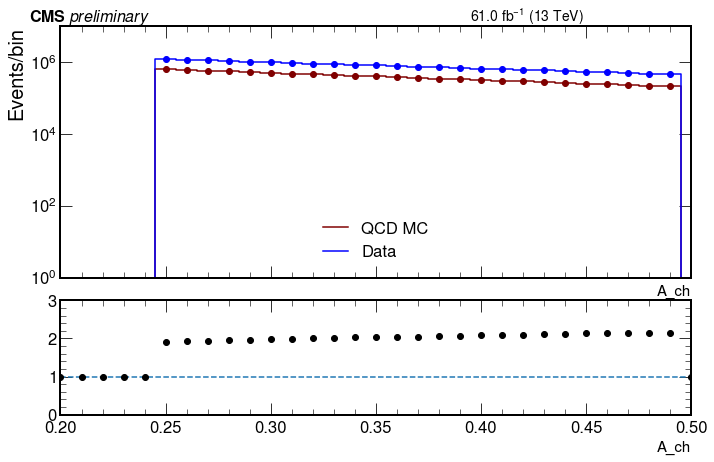

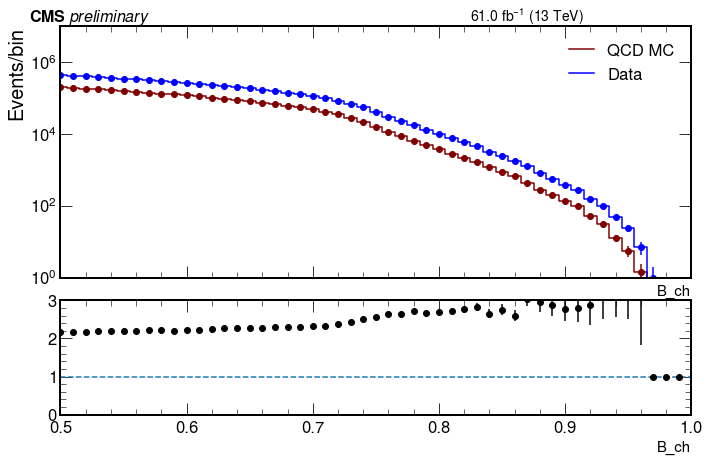

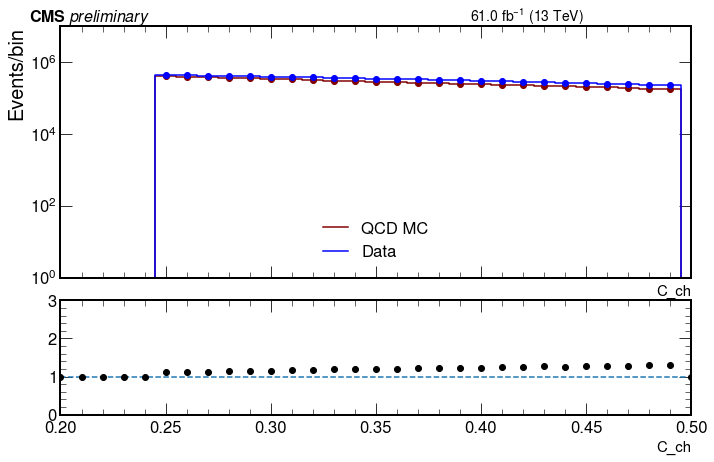

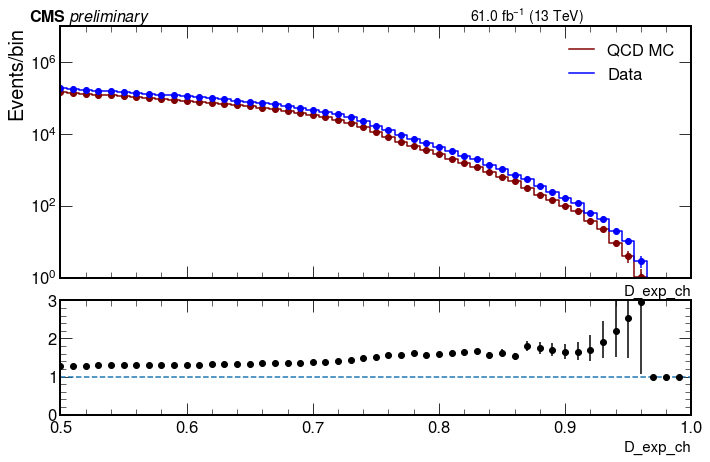

In [50]:
### Make ABCD plots and table based on selection (e.g. 'ch', 'mult')
selection = 'ch'
save = True
lumi = 61

for plot_label in ['A_'+selection,'B_'+selection,'C_'+selection,'D_exp_'+selection,'D_obs_'+selection]:
    
    if 'D_obs' in plot_label and (not unblind): continue    
    
    hQCD_MC = plots['QCD_MC'][plot_label]
    hdata = plots['data'][plot_label]

    #Set up variables for the stacked histogram
    plt.figure(figsize=(12,10))
    plt.gcf().subplots_adjust(bottom=0.15, left=0.17)
    ax1 = plt.subplot2grid((4,1), (0,0),rowspan=2)

    QCD_MC, x = hQCD_MC.to_numpy()
    QCD_MC = QCD_MC*lumi
    hQCD_MC_errs = np.sqrt(hQCD_MC.variances())*lumi
    ax1.step(x[:-1],QCD_MC, color='maroon',label="QCD MC", where='mid')
    ax1.errorbar(x[:-1],QCD_MC, yerr=hQCD_MC_errs, color="maroon".upper(), fmt='o')

    data, x = hdata.to_numpy()
    hdata_errs = np.sqrt(hdata.variances())
    ax1.step(x[:-1],data, color='blue',label="Data", where= 'mid')
    ax1.errorbar(x[:-1],data, yerr=hdata_errs, color="blue".upper(), fmt='o')
    
    
    #Set parameters that will be used to make the plots prettier
    ax1.set_yscale("log")
    ymax = 1e7
    ax1.set_ylim([1e0, ymax])
    if 'A_' in plot_label or 'C_' in plot_label:
        xmin = 0.2
        xmax = 0.5
        ax1.set_xlim([xmin,xmax])
    elif 'B_' in plot_label or 'D_' in plot_label:
        xmin = 0.5
        xmax = 1.0
        ax1.set_xlim([xmin,xmax])
    #max_y = ax1.gca().get_ylim()[1]
    max_y = ymax + ymax*0.2
    max_x = xmax
    min_x = xmin
    x_range = max_x - min_x
    lower_label = min_x - x_range*0.05
    upper_label = max_x - x_range*0.35
    

    #X and Y labels (Do not use the central matplotlob default), text, and legend
    ax1.set_xlabel(plot_label, x=1, ha='right', fontsize=15)
    ax1.set_ylabel("Events/bin", y=1, ha='right')
    cms_txt = ax1.text(
            lower_label, max_y*1.08, u"CMS $\it{preliminary}$",
            fontsize=16, fontweight='bold',
    )

    lumi_txt = ax1.text(
            upper_label, max_y*1.08, r"%.1f fb$^{-1}$ (13 TeV)" % lumi,
            fontsize=14, 
    )
    ax1.legend()

    ax2 = plt.subplot2grid((4,1), (2,0),sharex=ax1)
    plt.setp(ax1.get_xticklabels(), visible=False)
    
    # calculate the upper and lower errors
    # suppress errors where the denonminator is 0
    QCD_MC = np.where(QCD_MC>0, QCD_MC, -1)
    yerrors_up = np.where(QCD_MC>0, data/QCD_MC - (data-hdata_errs)/(QCD_MC+hQCD_MC_errs), np.nan)
    yerrors_low = np.where(QCD_MC>0, (data+hdata_errs)/(QCD_MC-hQCD_MC_errs) - data/QCD_MC, np.nan)
    yerrors = [yerrors_up, yerrors_low]

    ax2.errorbar(x[:-1],np.where((data>0) & (QCD_MC>0),data/QCD_MC,1),yerr=yerrors, color="black", fmt='o')
    ax2.axhline(1, ls="--")
    ax2.set_ylim(0,3)
    ax2.set_xlabel(plot_label, fontsize=15)
    if save: plt.savefig(output_label + "_" + plot_label+ "_closure_"+selection+file_ext)

## Table

Make comparison table by running next 3 cells. The output is meant to be in Latex format.

In [97]:
table = []
for i in range(len(list(SUEPdata.keys()))):
    label = list(SUEPdata.keys())[i]
    line = []
    line.append(label)
    
    for r in ['A_'+selection,'B_'+selection,'C_'+selection,'D_exp_'+selection,'D_obs_'+selection]:
        if 'QCD' in label:
            line.append("{:0.0f} ".format(SUEPdata[label][r]['value']) + r'$\pm$' + " {:0.0f}".format(SUEPdata[label][r]['err']))
        else:
            line.append("{:0.2f} ".format(SUEPdata[label][r]['value']) + r'$\pm$' + " {:0.2f}".format(SUEPdata[label][r]['err']))
        
    if 'QCD' in label:
        line.append(round((SUEPdata[label]['D_exp_'+selection]['value']-SUEPdata[label]['D_obs_'+selection]['value'])/SUEPdata[label]['D_exp_'+selection]['value'],2))
        line.append(0)
    else:
        line.append(0)
        line.append(SUEPdata[label]['D_obs_'+selection]['value']/math.sqrt(SUEPdata[label]['D_obs_'+selection]['value']+SUEPdata[label]['D_exp_'+selection]['value']+SUEPdata[label]['D_obs_'+selection]['err']+SUEPdata['QCD']['D_exp_'+selection]['err']))
    table.append(line)                                                         

In [98]:
t = tabulate(table,tablefmt ='latex',
               headers=['Process', 'A', 'B', 'C', 'D_{exp}', 'D_{obs}', 'D_{exp}-D_{obs}/D_{exp}', 'S/$\sqrt(S+B+\sigma_{S}+\sigma_{B}$)'])
with open('table.txt', 'w') as f:
    f.write(t)
t

'\\begin{tabular}{llllllrr}\n\\hline\n Process            & A                  & B                 & C                 & D\\_\\{exp\\}           & D\\_\\{obs\\}           &   D\\_\\{exp\\}-D\\_\\{obs\\}/D\\_\\{exp\\} &   S/\\$\\textbackslash{}sqrt(S+B+\\textbackslash{}sigma\\_\\{S\\}+\\textbackslash{}sigma\\_\\{B\\}\\$) \\\\\n\\hline\n SUEP-m1000-darkPho & 0.00 \\$\\textbackslash{}pm\\$ 0.00    & 0.00 \\$\\textbackslash{}pm\\$ 0.00   & 2.18 \\$\\textbackslash{}pm\\$ 1.48   & 0.00 \\$\\textbackslash{}pm\\$ 0.00   & 46.26 \\$\\textbackslash{}pm\\$ 6.80  &                      0    &                              1.19059   \\\\\n SUEP-m750-darkPho  & 0.00 \\$\\textbackslash{}pm\\$ 0.00    & 0.00 \\$\\textbackslash{}pm\\$ 0.00   & 1.57 \\$\\textbackslash{}pm\\$ 1.25   & 0.00 \\$\\textbackslash{}pm\\$ 0.00   & 19.48 \\$\\textbackslash{}pm\\$ 4.41  &                      0    &                              0.506162  \\\\\n SUEP-m400-darkPho  & 0.00 \\$\\textbackslash{}pm\\$ 0.00    & 0.00 \\$

In [99]:
def convert2LatexString(s):
    r = r'(\^\{\})'; s = re.sub(r, "^", s)
    s = re.sub(r'\\([\$\_\{\}\^])', r'\1', s)
    s = re.sub(r'(\\textbackslash{})', r'\\', s)
    return s

t = convert2LatexString(t)
with open('table.txt', 'w') as f:
    f.write(t)
t

'\\begin{tabular}{llllllrr}\n\\hline\n Process            & A                  & B                 & C                 & D_{exp}           & D_{obs}           &   D_{exp}-D_{obs}/D_{exp} &   S/$\\sqrt(S+B+\\sigma_{S}+\\sigma_{B}$) \\\\\n\\hline\n SUEP-m1000-darkPho & 0.00 $\\pm$ 0.00    & 0.00 $\\pm$ 0.00   & 2.18 $\\pm$ 1.48   & 0.00 $\\pm$ 0.00   & 46.26 $\\pm$ 6.80  &                      0    &                              1.19059   \\\\\n SUEP-m750-darkPho  & 0.00 $\\pm$ 0.00    & 0.00 $\\pm$ 0.00   & 1.57 $\\pm$ 1.25   & 0.00 $\\pm$ 0.00   & 19.48 $\\pm$ 4.41  &                      0    &                              0.506162  \\\\\n SUEP-m400-darkPho  & 0.00 $\\pm$ 0.00    & 0.00 $\\pm$ 0.00   & 0.45 $\\pm$ 0.67   & 0.00 $\\pm$ 0.00   & 4.87 $\\pm$ 2.21   &                      0    &                              0.127279  \\\\\n SUEP-m125-darkPho  & 0.07 $\\pm$ 0.26    & 0.10 $\\pm$ 0.32   & 0.29 $\\pm$ 0.54   & 0.41 $\\pm$ 0.64   & 0.78 $\\pm$ 0.88   &                      0 